In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import os
import logging
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

from __init__ import *
from snmcseq_utils import create_logger
from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels

# from scipy.stats import gaussian_kde

# from snmcseq_utils import plot_tsne_labels
# from snmcseq_utils import tsne_and_boxplot

- How do we choose thresholds and conditions?
- For a fixed filtering threshold, what outputs do we want to see?

# recommended parameters:
- mCH: 0.8, 250, 4000
- mCA: 0.8, 100, 1400
- mCG: 0.8, 10, 300

In [3]:
log = create_logger()

In [4]:

def normalize_by_global(df_mcc, df_meta, context):
    """
    normalize a mcc dataframe by global mcc level
    """
    logging.info('Normalize by global m%s ...' % context)
    df_nmcc = pd.DataFrame()
    
    for idx, row in df_meta.iterrows():
        samp = idx 
        if context == 'CH':
            df_nmcc[samp] = (df_mcc[samp] / (row['mCH/CH']+.01))
        elif context == 'CG':
            df_nmcc[samp] = (df_mcc[samp] / (row['mCG/CG']+.01))
        else:
            raise ValueError('Wrong context: %s' % context)
    return df_nmcc


In [5]:
# set up paths
ens = 'Ens1'
context = 'CH'
bin_size = BIN_SIZE_FEATURE
ens_path = os.path.join(PATH_ENSEMBLES, ens)
meta_file = os.path.join(ens_path, 'mapping_summary_{}.tsv'.format(ens))
binc_file = os.path.join(ens_path, 'binc/binc_m{}_{}_{}.tsv.bgz'.format(context, bin_size, ens))

output_summary = os.path.join(ens_path, 'binc_m{}_{}_QC_summary_{}.tsv'.format(context, bin_size, ens))
output_plot = os.path.join(ens_path, 'plots/binc_m{}_{}_QC_plot_{}.pdf'.format(context, bin_size, ens)) 
output_cellcovr = os.path.join(ens_path, 'binc_m{}_{}_QC_cells_covr_{}.tsv'.format(context, bin_size, ens))
output_nmcc = os.path.join(ens_path, 'binc/binc_m{}_{}_nmcc_{}.tsv'.format(context, bin_size, ens))

In [6]:
# mch file
df = pd.read_table(binc_file, index_col=['chr', 'bin'], 
                   compression='gzip', dtype={'chr': object})
print(df.shape)
df.iloc[500:505, :10]

(25475, 2404)


171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed_mc  \
chr bin                                                                                               
1   50000000                                                 21                                       
    50100000                                                 11                                       
    50200000                                                 27                                       
    50300000                                                 18                                       
    50400000                                                 15                                       

              171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed_c  \
chr bin                                                                                              
1   50000000                                                995                                      
    50100000                                                655                                      
    50200000                                               1193                                      
    50300000                                                961                                      
    50400000                                               1000                                      

              171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed_mc  \
chr bin                                                                                               
1   50000000                                                 37                                       
    50100000                                                 58                                       
    50200000                                                 21                                       
    50300000                                                 46                                       
    50400000                                                 19                                       

              171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed_c  \
chr bin                                                                                              
1   50000000                                               1387                                      
    50100000                                               1583                                      
    50200000                                                643                                      
    50300000                                               1215                                      
    50400000                                                846                                      

              171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed_mc  \
chr bin                                                                                               
1   50000000                                                 14                                       
    50100000                                                 15                                       
    50200000                                                 30                                       
    50300000                                                 16                                       
    50400000                                                  9                                       

              171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed_c  \
chr bin                                                                                              
1   50000000                                                898                                      
    50100000                                               1448                                      
    502000

In [7]:
# metadata
df_meta = pd.read_table(meta_file, index_col='Sample')
print(df_meta.shape)

(1202, 14)


In [8]:
df_mc = df.filter(regex='_mc$')
df_c = df.filter(regex='_c$')

df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 

print(df_mc.shape)
print(df_c.shape)

(25475, 1202)
(25475, 1202)


In [21]:
# bins 


# low coverage
base_call_cutoff = 250

df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan

nonnulls = 1 - df_c_nan.isnull()
fbins = nonnulls.sum(axis=1)/nonnulls.shape[1]
fcells = nonnulls.sum(axis=0)/nonnulls.shape[0]

# rank bins by fbins and get top 80% for each chromosome 
# remove high coveraged ones
dfs = []
for chrom, sr_sub in fbins.groupby('chr'):
    num_bins = sr_sub.shape[0]
    dfs.append(sr_sub.nlargest(int(0.8*num_bins)))
dfs = pd.concat(dfs)    
# df_c.loc[dfs.index].shape
condition_low = fbins.index.isin(dfs.index) # just for the purpose of re-ordering index 


# high coverage
high_mean = 4000
condition_high = df_c.mean(axis=1) < high_mean 

# condition
condition = condition_high & condition_low               

# status after preprocessing
lower_limit = fbins[condition_low].nsmallest(10).mean()
num_high_removed = np.sum(~condition_high)

num_kept = fbins[condition].shape[0]
num_orig = fbins.shape[0]
frac_kept = num_kept/num_orig

fbins_after = nonnulls[condition].sum(axis=1)/nonnulls[condition].shape[1]
fcells_after = nonnulls[condition].sum(axis=0)/nonnulls[condition].shape[0]

summary = ( 
'''***** Preprocessing summary *****
Number of bins kept: {}/{} ({})
Lower limit of coverage: {}
Number of removed high coverage bins: {}
***** End of preprocessing summary *****
''').format(
    fbins[condition].shape[0], fbins.shape[0], fbins[condition].shape[0]/fbins.shape[0], 
    lower_limit, num_high_removed)

logging.info(summary)
with open(output_summary, 'w') as file:
    file.write(summary)

02/07/2018 03:58:01 PM ***** Preprocessing summary *****
Number of bins kept: 20366/25475 (0.799450441609421)
Lower limit of coverage: 0.9176372712146422
Number of removed high coverage bins: 8
***** End of preprocessing summary *****



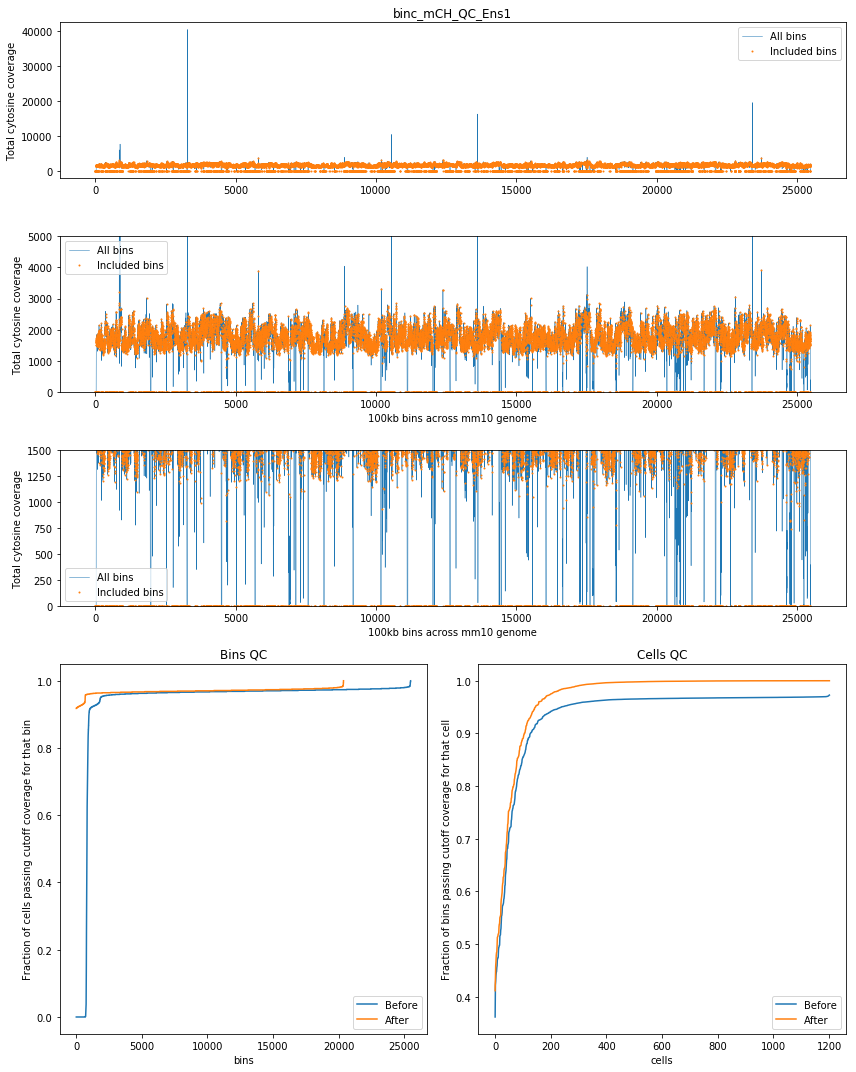

In [22]:
# plot

# evaluate the filtering process (what're kept)
baseline = df_c.mean(axis=1)
exp = condition.values*baseline.values
if not os.path.exists(os.path.join(ens_path, 'plots')):
    os.makedirs(os.path.join(ens_path, 'plots'))

fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(5, 2)
ax = fig.add_subplot(gs[0, :])
ax.set_title('binc_m{}_QC_{}'.format(context, ens))
ax.plot(baseline.values, linewidth=0.5, label='All bins')
ax.plot(exp, 'o', markersize=1, label='Included bins')
ax.legend()
ax.set_ylabel('Total cytosine coverage')

ax = fig.add_subplot(gs[1, :])
ax.plot(baseline.values, linewidth=0.5, label='All bins')
ax.plot(exp, 'o', markersize=1, label='Included bins')
ax.legend()
ax.set_ylim([0, 5000])
ax.set_xlabel('100kb bins across mm10 genome')
ax.set_ylabel('Total cytosine coverage')

ax = fig.add_subplot(gs[2, :])
ax.plot(baseline.values, linewidth=0.5, label='All bins')
ax.plot(exp, 'o', markersize=1, label='Included bins')
ax.legend()
ax.set_ylim([0, 1500])
ax.set_xlabel('100kb bins across mm10 genome')
ax.set_ylabel('Total cytosine coverage')

ax = fig.add_subplot(gs[3:, 0])
ax.plot(fbins.sort_values().values, label='Before')
ax.plot(fbins_after.sort_values().values, label='After')
ax.legend()
ax.set_title('Bins QC')
ax.set_xlabel('bins')
ax.set_ylabel('Fraction of cells passing cutoff coverage for that bin')

ax = fig.add_subplot(gs[3:, 1])
ax.plot(fcells.sort_values().values, label='Before')
ax.plot(fcells_after.sort_values().values, label='After')
ax.legend()
ax.set_title('Cells QC')
ax.set_xlabel('cells')
ax.set_ylabel('Fraction of bins passing cutoff coverage for that cell')

fig.tight_layout()
fig.savefig(output_plot)
plt.show()




In [23]:
# files (cell conf level)

cells_covr = pd.merge(fcells.to_frame(), fcells_after.to_frame(), left_index=True, right_index=True)
cells_covr.columns=['covr_before', 'covr_after']
cells_covr = cells_covr.rename_axis('sample')
cells_covr.to_csv(output_cellcovr, sep='\t', na_rep='NA', header=True, index=True)
logging.info("Saved cells coverage info to {}".format(output_cellcovr))

02/07/2018 03:58:07 PM Saved cells coverage info to /cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens1/binc_mCH_100000_QC_cells_covr_Ens1.tsv


In [153]:
# nmcc file


df_mcc = df_mc[condition]/df_c_nan[condition]
# normalization (normalized by global mcc)
logging.info('Normalization...')
df_mcc = normalize_by_global(df_mcc, df_meta, context)

# imputation (missing value -> mean value of all cells)
logging.info('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'
logging.info('Done preprocess bins...\nOutput shape: {}'.format(df_mcc.shape))

# save to output
df_mcc.to_csv(output_nmcc, sep='\t', na_rep='NA', header=True, index=True)
logging.info('Saved file to: {}'.format(output_nmcc))

02/06/2018 11:56:37 AM Normalization...
02/06/2018 11:56:37 AM Normalize by global mCH ...
02/06/2018 11:56:39 AM Imputing data...
02/06/2018 11:56:41 AM Done preprocess bins...
Output shape: (20353, 1261)
02/06/2018 11:57:17 AM Saved file to: /cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens4/binc/binc_mCH_nmcc_Ens4.tsv


###

In [9]:
# Filter out bins with low and high coverage ...
# Keep only bins that have sufficient coverage in at least 99.5% of all cells


# low coverage
base_call_cutoff = 100 
sufficient_coverage_fraction = 0.96

base_call_cutoff_v2 = 100 
sufficient_coverage_fraction_v2 = 0.92

high_mean = 1200

condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
condition3 = (df_c > base_call_cutoff_v2).sum(axis=1) >= sufficient_coverage_fraction_v2*df_c.shape[1] 
# high coverage
condition2 = df_c.mean(axis=1) < high_mean 
condition = ((condition1 | (condition3 & (df_c.index.get_level_values(0)=='X'))) & condition2)

df_f = df.loc[condition]
print("Matrix size before pruning... "+ str(df.shape))
print("Matrix size after pruning... "+ str(df_f.shape))
print("Fraction of bins passing thresholds: "+ str(df_f.shape[0]/df.shape[0]))
print("Matrix size before pruning for chrX... "+ str(df[df.index.get_level_values(0)=='X'].shape))
print("Matrix size after pruning for chrX... "+ str(df_f[df_f.index.get_level_values(0)=='X'].shape))
print("Fraction of bins passing thresholds for chrX: "+ 
      str(df_f[df_f.index.get_level_values(0)=='X'].shape[0]/df[df.index.get_level_values(0)=='X'].shape[0]))

# get mcc matrix with kept bins and nan values for low coverage sites
# df_c_nan = df_c.copy()
# df_c_nan[df_c < base_call_cutoff] = np.nan
# df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]

df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
# df_c_nan = df_c_nan[condition]
nonnulls = 1 - df_c_nan.isnull()

fbins = nonnulls.sum(axis=1)/nonnulls.shape[1]
fcells = nonnulls.sum(axis=0)/nonnulls.shape[0]

print("Mean cells {}".format(fbins.mean()))
print("Mean bins {}".format(fcells.mean()))

Matrix size before pruning... (25475, 2404)
Matrix size after pruning... (22443, 2404)
Fraction of bins passing thresholds: 0.880981354268891
Matrix size before pruning for chrX... (855, 2404)
Matrix size after pruning for chrX... (605, 2404)
Fraction of bins passing thresholds for chrX: 0.7076023391812866
Mean cells 0.935325096053519
Mean bins 0.935325096053519


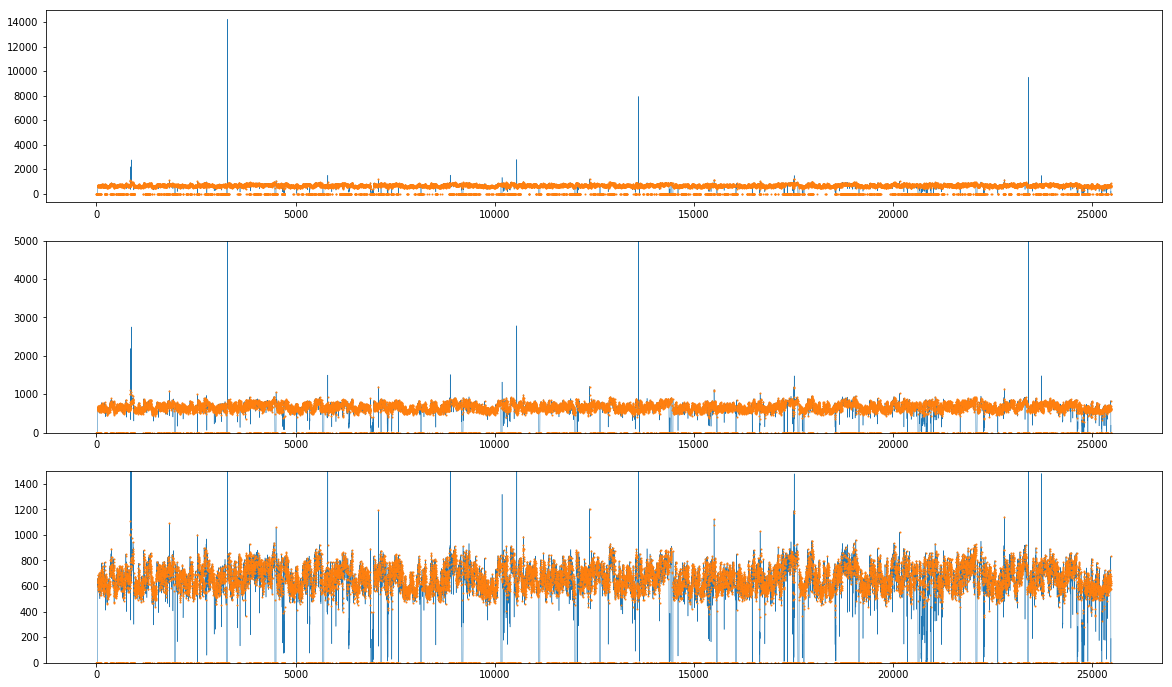

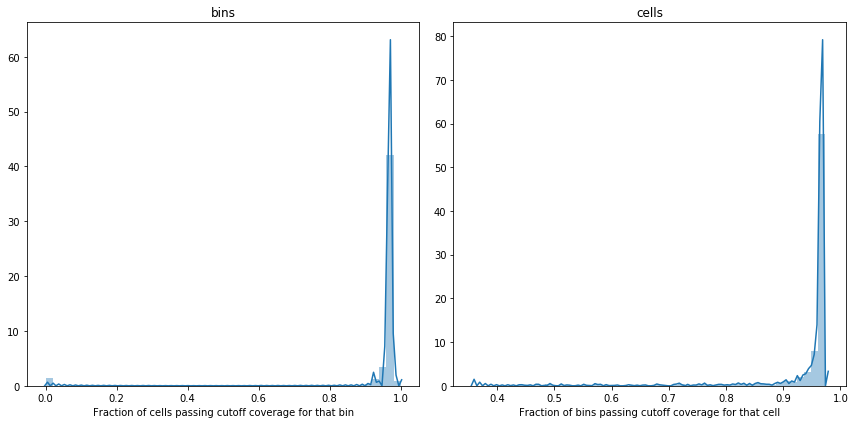

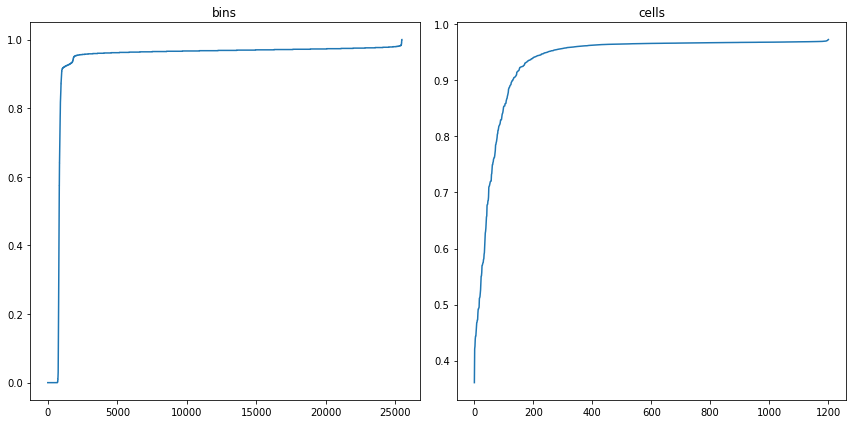

In [86]:
# evaluate the filtering process (what're kept)
baseline = df_c.mean(axis=1)
exp = condition.values*baseline.values
fig, axs = plt.subplots(3, 1, figsize=(20,12))
ax = axs[0]
# title = '''m{}; base call cutoff = {}
#         sufficient coverage fraction = {}
#         base call cutoff2 = {}
#         sufficient coverage fraction2 = {}
#         high_mean = {}'''.format(context, base_call_cutoff, sufficient_coverage_fraction, 
#                                  base_call_cutoff_v2, sufficient_coverage_fraction_v2, high_mean)
# ax.set_title(title)
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax = axs[1]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([0, 5000])
ax = axs[2]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([0, 1500])
# plt.savefig('./results/pre')
plt.show()


# evalute after the filtering
# flag these cells
fig, axs = plt.subplots(1, 2, figsize=(12,6))
ax = axs[0]
sns.distplot(fbins, ax=ax, norm_hist=True)
ax.set_xlabel('Fraction of cells passing cutoff coverage for that bin')
ax.set_title('bins')

ax = axs[1]
sns.distplot(fcells, ax=ax, norm_hist=True)
ax.set_xlabel('Fraction of bins passing cutoff coverage for that cell')
ax.set_title('cells')
fig.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.plot(fbins.sort_values().values)
ax.set_title('bins')

ax = axs[1]
ax.plot(fcells.sort_values().values)
ax.set_title('cells')
fig.tight_layout()



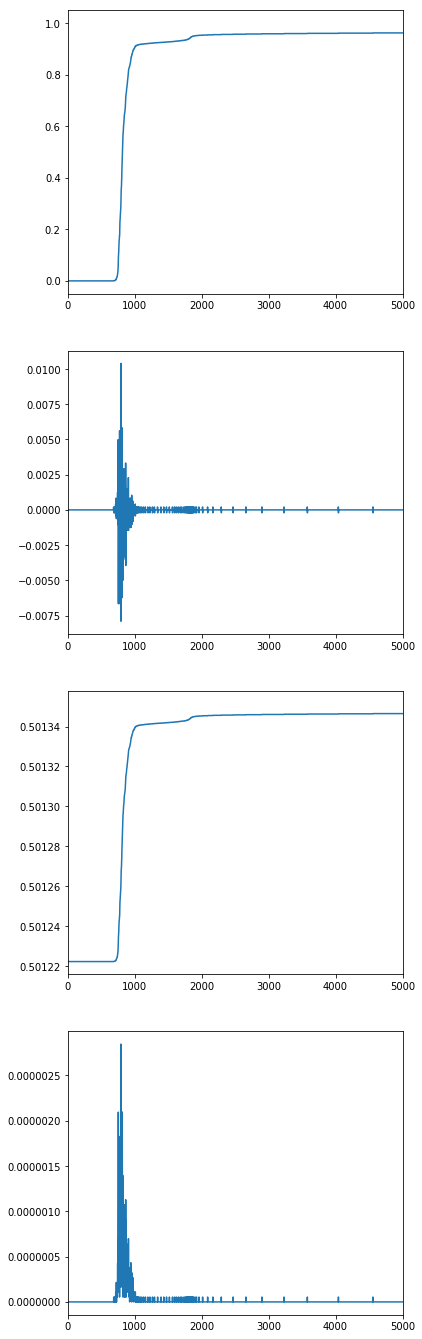

In [29]:
from scipy.interpolate import UnivariateSpline

x = np.arange(len(fbins))
y = fbins.sort_values().values

spl = UnivariateSpline(x, y)

fig, axs = plt.subplots(4, 1, figsize=(6,24))

ax = axs[0]
ax.plot(y)
ax.set_xlim([0,5000])

ax = axs[1]
ax.plot(np.gradient(np.gradient(y)))
ax.set_xlim([0,5000])

ax = axs[2]
ax.plot(x, spl(y))
ax.set_xlim([0,5000])

ax = axs[3]
ax.plot(x, np.gradient(spl(y)))
ax.set_xlim([0,5000])
plt.show()


In [43]:
# run 2d parameter searching colored by fraction of bins and fraction of cells included
ti = time.time()
bcf = np.arange(0, 500.1, 50) 
scf_bin = np.arange(0.9, 1.001, 0.01)
paras_bin = itertools.product(bcf, scf_bin)

res_bin = []
for i, (base_call_cutoff, sufficient_coverage_fraction) in enumerate(paras_bin):
    # low coverage condition
    print('.', end='')
    condition_bin = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
    # fraction of bins included
    res = np.sum(condition_bin.values*1)/df_c.shape[0]
    res_bin.append({'bcf': base_call_cutoff,
                     'scf': sufficient_coverage_fraction, 
                     'res': res})

tf = time.time()
print("time: {} sec".format(tf - ti))


ti = time.time()
bcf = np.arange(0, 200, 50) 
scf_cell = np.arange(0.9, 1.001, 0.01)
paras_cell = itertools.product(bcf, scf_cell)

res_cell = []
for i, (base_call_cutoff, sufficient_coverage_fraction) in enumerate(paras_cell):
    # low coverage condition
    print('.', end='')
    condition_cell = (df_c > base_call_cutoff).sum(axis=0) >= sufficient_coverage_fraction*df_c.shape[0] 
    # fraction of bins included
    res = np.sum(condition_cell.values*1)/df_c.shape[1]
    res_cell.append({'bcf': base_call_cutoff,
                     'scf': sufficient_coverage_fraction, 
                     'res': res})

tf = time.time()
print("time: {} sec".format(tf - ti))



.........................................................................................................................time: 13.380949974060059 sec
............................................time: 4.779619216918945 sec


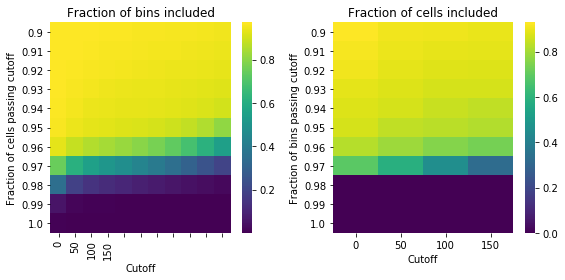

In [44]:
df_res_bin = pd.DataFrame(res_bin)
df_res_bin = pd.pivot_table(df_res_bin, values='res', index='scf', columns='bcf')

df_res_cell = pd.DataFrame(res_cell)
df_res_cell = pd.pivot_table(df_res_cell, values='res', index='scf', columns='bcf')

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
sns.heatmap(df_res_bin, cmap='viridis', ax=ax)
ax.set_title('Fraction of bins included')
ax.set_ylabel('Fraction of cells passing cutoff')
ax.set_xlabel('Cutoff')

ax.set_xticklabels(bcf)
ax.set_yticklabels([str(val)[:4] for val in scf_bin])
ax = axs[1]
sns.heatmap(df_res_cell, cmap='viridis', ax=ax)
ax.set_title('Fraction of cells included')
ax.set_ylabel('Fraction of bins passing cutoff')
ax.set_xlabel('Cutoff')
ax.set_xticklabels(bcf)
ax.set_yticklabels([str(val)[:4] for val in scf_cell])
fig.tight_layout()
plt.show()

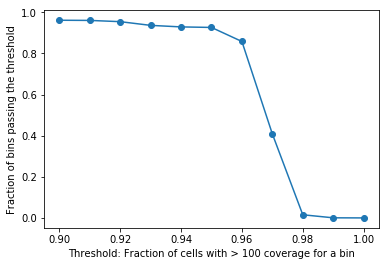

In [117]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

scf = np.arange(0.90, 1.001, 0.01)
res_list = []
base_call_cutoff = 100 
for sufficient_coverage_fraction in scf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
    # summarized condition
    condition = condition1 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(scf, res_list, '-o')
ax.set_xlabel('Threshold: Fraction of cells with > {} coverage for a bin'.format(base_call_cutoff))
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

...........

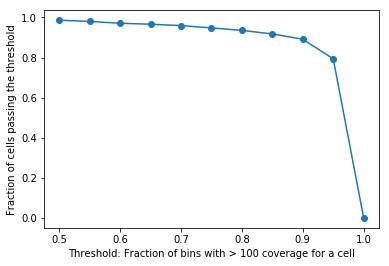

In [114]:
scf = np.arange(0.5, 1.01, 0.05)
res_list = []
base_call_cutoff = 100 
for sufficient_coverage_fraction in scf:
    # low coverage
    print('.', end='')
    condition1 = (df_c > base_call_cutoff).sum(axis=0) >= sufficient_coverage_fraction*df_c.shape[0] 
    # summarized condition
    condition = condition1 
    # fraction of bins included
    res = np.sum(condition.values*1)/df_c.shape[1]
    res_list.append(res)


# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(scf, res_list, '-o')
ax.set_xlabel('Threshold: Fraction of bins with > {} coverage for a cell'.format(base_call_cutoff))
ax.set_ylabel('Fraction of cells passing the threshold')
plt.show()

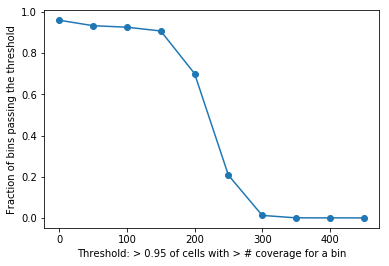

In [64]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

sufficient_coverage_fraction = 0.95
high_mean = 1200
res_list = []
bcf = np.arange(0, 500, 50) 
for base_call_cutoff in bcf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
    # high coverage
    condition2 = df_c.mean(axis=1) < high_mean 
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

    
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(bcf, res_list, '-o')
ax.set_xlabel('Threshold: > {} of cells with > # coverage for a bin'.format(sufficient_coverage_fraction))
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

In [10]:
# choose a condition to move forward

context = 'CH'
# low coverage
base_call_cutoff = 100 
sufficient_coverage_fraction = 0.96

base_call_cutoff_v2 = 100 
sufficient_coverage_fraction_v2 = 0.92

high_mean = 1200

condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*df_c.shape[1] 
condition3 = (df_c > base_call_cutoff_v2).sum(axis=1) >= sufficient_coverage_fraction_v2*df_c.shape[1] 
# high coverage
condition2 = df_c.mean(axis=1) < high_mean 
condition = ((condition1 | (condition3 & (df_c.index.get_level_values(0)=='X'))) & condition2)

df_f = df.loc[condition]
print("Matrix size before pruning... "+ str(df.shape))
print("Matrix size after pruning... "+ str(df_f.shape))
print("Fraction of bins passing thresholds: "+ str(df_f.shape[0]/df.shape[0]))
print("Matrix size before pruning for chrX... "+ str(df[df.index.get_level_values(0)=='X'].shape))
print("Matrix size after pruning for chrX... "+ str(df_f[df_f.index.get_level_values(0)=='X'].shape))
print("Fraction of bins passing thresholds for chrX: "+ 
      str(df_f[df_f.index.get_level_values(0)=='X'].shape[0]/df[df.index.get_level_values(0)=='X'].shape[0]))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
nonnulls = 1 - df_c_nan.isnull()
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]

fbins = nonnulls.sum(axis=1)/nonnulls.shape[1]
fcells = nonnulls.sum(axis=0)/nonnulls.shape[0]

print("Mean cells {}".format(fbins.mean()))
print("Mean bins {}".format(fcells.mean()))


# normalization (normalized by global mcc)
print('Normalization...')
df_mcc = normalize_by_global(df_mcc, df_meta, context)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'
print('Done preprocess bins...')

Matrix size before pruning... (25475, 2404)
Matrix size after pruning... (22443, 2404)
Fraction of bins passing thresholds: 0.880981354268891
Matrix size before pruning for chrX... (855, 2404)
Matrix size after pruning for chrX... (605, 2404)
Fraction of bins passing thresholds for chrX: 0.7076023391812866
Mean cells 0.935325096053519
Mean bins 0.935325096053519
Normalization...
Normalize by global mCH ...
Imputing data...
Done preprocess bins...


In [11]:
# try tSNE by 

# remove those cells (0.9 bins)
# mark those cells (generate confidence table)

print(df_mcc.shape)
df_mcc.head()
output_file = os.path.join(ens_path, 'binc/binc_m{}_norm_{}_{}.tsv'.format(context, ens, 10*BIN_SIZE))
print(output_file)

(22443, 1202)
/cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens1/binc/binc_mCH_norm_Ens1_100000.tsv


In [13]:
# 50 PC and tsne

def run_tsne(df, perp, n_pc=50, n_tsne=2, 
             random_state=1, output_file=None):
   
    ti = time.time()
    
    df = df.filter(regex='_mcc$')
    logging.info("Running tsne: {} PC and {} tSNE.\nInput shape: {}".format(n_pc, n_tsne, df.shape))
    
    pca = PCA(n_components=n_pc)
    pcs = pca.fit_transform(df.T)

    tsne = TSNE(n_components=n_tsne, init='pca', random_state=random_state, perplexity=perp, verbose=3)
    ts = tsne.fit_transform(pcs)
    
    df_tsne = pd.DataFrame(ts, columns=['tsne_x','tsne_y'])
    df_tsne['sample'] = [sample[:-len('_mcc')] for sample in df.columns.tolist()]
    df_tsne = df_tsne.set_index('sample')
    
    if output_file:
        logging.info("Saving output to file.")
        df_tsne.to_csv(output_file, sep="\t", na_rep='NA', header=True, index=True)

    tf = time.time()
    logging.info("Done with tSNE. running time: %.2f seconds." % (tf - ti))
    
    return df_tsne


In [14]:
df_tsne = run_tsne(df_mcc, perp=30)
print(df_tsne.shape)
print(df_tsne.head())

# df_tsne_v2 = run_tsne(df_mcc[fcells[fcells>=0.9].index.values+'_mcc'], perp=30)
# print(df_tsne_v2.shape)
# print(df_tsne_v2.head())

02/03/2018 10:28:55 PM Running tsne: 50 PC and 2 tSNE.
Input shape: (22443, 1202)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1202 samples in 0.002s...
[t-SNE] Computed neighbors for 1202 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1202
[t-SNE] Computed conditional probabilities for sample 1202 / 1202
[t-SNE] Mean sigma: 7.751559
[t-SNE] Computed conditional probabilities in 0.085s
[t-SNE] Iteration 50: error = 47.4764442, gradient norm = 0.1409138 (50 iterations in 0.963s)
[t-SNE] Iteration 100: error = 47.6709290, gradient norm = 0.1094127 (50 iterations in 0.881s)
[t-SNE] Iteration 150: error = 47.8964500, gradient norm = 0.1058947 (50 iterations in 0.902s)
[t-SNE] Iteration 200: error = 48.1550598, gradient norm = 0.1311944 (50 iterations in 0.902s)
[t-SNE] Iteration 250: error = 49.0462532, gradient norm = 0.0953486 (50 iterations in 0.887s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.046253
[t-SNE] Iteration 300: error = 0.5358677, gradient norm = 0.0008251 (50 iterations in 0.921s)

02/03/2018 10:29:17 PM Done with tSNE. running time: 22.06 seconds.


[t-SNE] Iteration 1000: error = 0.4261181, gradient norm = 0.0001625 (50 iterations in 0.874s)
[t-SNE] Error after 1000 iterations: 0.426118
(1202, 2)
                                                       tsne_x     tsne_y
sample                                                                  
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4...  -3.155470  -7.326878
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1...   0.317423 -25.495892
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1... -10.937735  46.480381
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1... -24.195724  16.930975
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4...   2.791611 -44.071789


In [17]:
# louvain clustering
from louvain_jaccard import louvain_jaccard 

df_cluster, summary = louvain_jaccard(df_mcc, n_pc=50, k=30, sub_ncells=None, output_file=None)

print(df_cluster.shape)
df_cluster.head()


Input shape (n_obs, n_features): (1202, 22443)
Done with clustering!
(1202, 1)


,cluster_ID
sample,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed,cluster_9
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G4_AD008_indexed,cluster_3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C3_AD002_indexed,cluster_12
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H3_AD002_indexed,cluster_8
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B7_AD002_indexed,cluster_4


In [49]:
df_conf = fcells.to_frame()
df_conf.columns = ['conf']
df_conf.head()

,conf
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed,0.947674
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed,0.961060
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed,0.960275
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed,0.957409
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed,0.961060


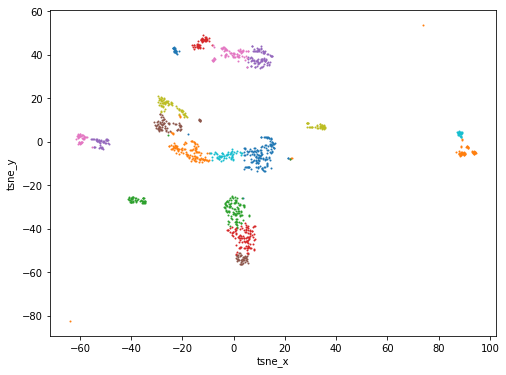

(1202, 3)
/cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens1/tsne_cluster_Ens1_test1.tsv


In [27]:
# visualize
# df_plot = pd.merge(df_tsne, df_conf, left_index=True, right_index=True) 
# plot_tsne_values(df_plot, tc='conf', low_p=5, hi_p=95)
# df_plot = pd.merge(df_tsne_v2, df_conf, left_index=True, right_index=True) 
# plot_tsne_values(df_plot, tc='conf', low_p=5, hi_p=95)
df_plot = pd.merge(df_tsne, df_cluster, left_index=True, right_index=True) 
plot_tsne_labels(df_plot, tc='cluster_ID', legend_mode=-1)

print(df_plot.shape)
df_plot.head()

output = os.path.join(ens_path, 'tsne_cluster_{}_test1.tsv'.format(ens))
df_plot.to_csv(output, sep="\t", na_rep='NA', header=True, index=True)

In [118]:
df_mcc.iloc[:5,:5]
output_file = './data/binc/binc_mCH_human_combined_100000_summary_nmcc_v4.tsv'

df_mcc.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)

# mCG 

In [2]:
# mcg file
context = 'CG'
input_file = './data/binc/binc_mCG_human_combined_100000_summary.tsv'
df = pd.read_table(input_file, index_col=['chr', 'bin'], 
                       dtype={'chr': object})
print(df.shape)

# metadata
meta_file = './data/metadata/metadata_human_combined_updated.tsv'
df_meta = pd.read_table(meta_file, index_col='Sample')
print(df_meta.shape)

(30353, 12870)
(6435, 16)


In [3]:
df_mc = df.filter(regex='_mc$')
df_c = df.filter(regex='_c$')

df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 

print(df_mc.shape)
print(df_c.shape)

(30353, 6435)
(30353, 6435)


In [16]:
# Filter out bins with low and high coverage ...
# Keep only bins that have sufficient coverage in at least 99.5% of all cells

# low coverage
base_call_cutoff = 10 
sufficient_coverage_fraction = 0.95
condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

# high coverage
condition2 = df_c.mean(axis=1) < 500

condition = (condition1 & condition2) 

print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
# df_c_nan = df_c.copy()
# df_c_nan[df_c < base_call_cutoff] = np.nan
# df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]

Matrix size before pruning... (30353, 12870)
Matrix size after pruning... (23022, 12870)


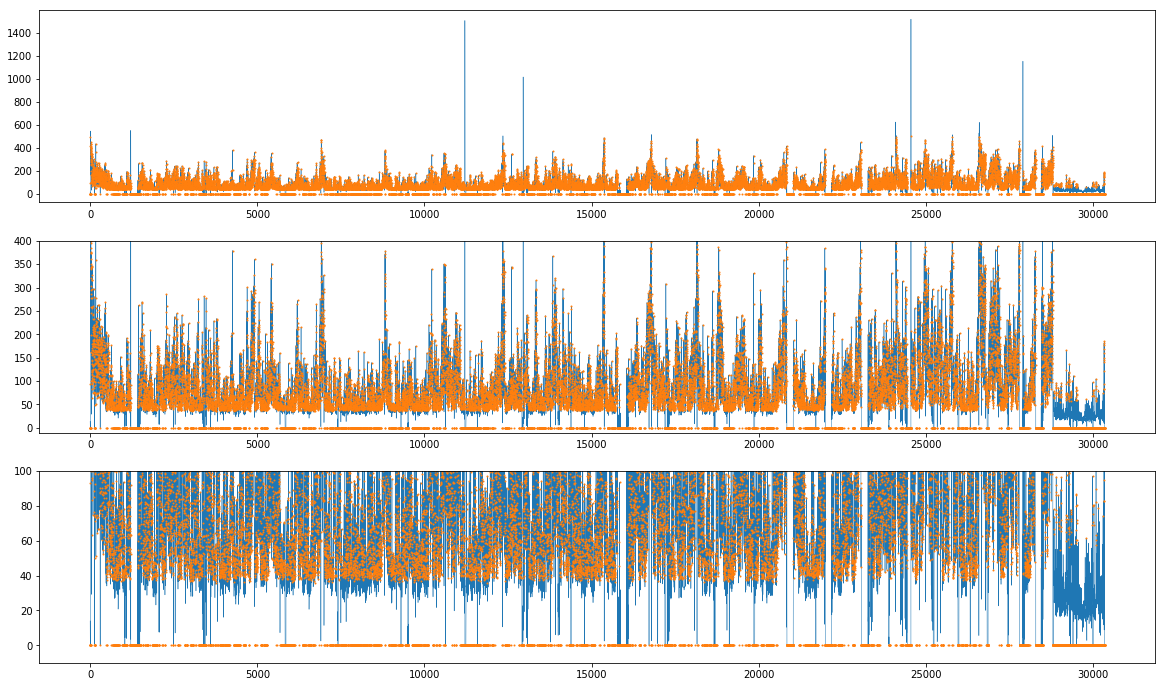

In [18]:
# evaluate the filtering process (what're kept)
baseline = df_c.mean(axis=1)
exp = condition.values*baseline.values
fig, axs = plt.subplots(3, 1, figsize=(20,12))
ax = axs[0]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax = axs[1]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([-10, 400])
ax = axs[2]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([-10, 100])
# plt.savefig('./results/pre')
plt.show()


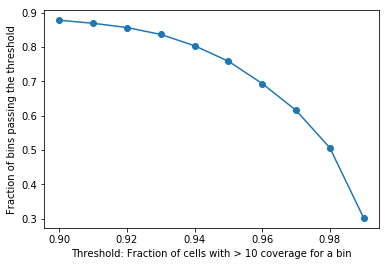

In [6]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

scf = np.arange(0.9, 1, 0.01)
res_list = []
base_call_cutoff = 10 
for sufficient_coverage_fraction in scf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 
    # high coverage
    condition2 = df_c.mean(axis=1) < 500
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

    
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(scf, res_list, '-o')
ax.set_xlabel('Threshold: Fraction of cells with > %d coverage for a bin' % base_call_cutoff)
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

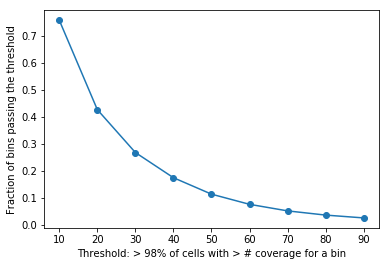

In [19]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

sufficient_coverage_fraction = 0.95
res_list = []
bcf = np.arange(10, 100, 10) 
for base_call_cutoff in bcf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 
    # high coverage
    condition2 = df_c.mean(axis=1) < 500
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

    
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(bcf, res_list, '-o')
ax.set_xlabel('Threshold: > 98% of cells with > # coverage for a bin')
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

In [35]:
# choose a condition to move forward

# low coverage
base_call_cutoff = 10 
sufficient_coverage_fraction = 0.95
condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

# high coverage
condition2 = df_c.mean(axis=1) < 500

condition = (condition1 & condition2) 

print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]


# normalization (normalized by global mcc)
print('Normalization...')
df_mcc = normalize_by_global(df_mcc, df_meta, 'CG')

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'

Matrix size before pruning... (30353, 12870)
Matrix size after pruning... (23022, 12870)
Normalization...
Normalize by global mCG ...
Imputing data...


In [36]:
df_mcc.iloc[:5,:5]

output_file = './data/binc/binc_mCG_human_combined_100000_summary_nmcc_v4.tsv'
df_mcc.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)

# mCH and mCG

In [37]:
# concatenate mCH and mCG normalize each feature by its standard deviation

input_mch = './data/binc/binc_mCH_human_combined_100000_summary_nmcc_v3.tsv'
input_mcg = './data/binc/binc_mCG_human_combined_100000_summary_nmcc_v3.tsv'

df_mch = pd.read_table(input_mch, index_col=['chr', 'bin'], dtype={'chr': object})
df_mcg = pd.read_table(input_mcg, index_col=['chr', 'bin'], dtype={'chr': object})

print(df_mch.shape)
print(df_mcg.shape)

(26058, 6435)
(23022, 6435)


In [38]:
df_mcg.iloc[:5, :5]


170508_MB_EA_hs_58yr_BA10_pool_1873_AD006_indexed_mcc  \
chr bin                                                              
1   700000                                            0.714391       
    800000                                            0.664107       
    900000                                            0.878970       
    1000000                                           0.890401       
    1300000                                           0.735449       

             170508_MB_EA_hs_58yr_BA10_pool_1874_AD010_indexed_mcc  \
chr bin                                                              
1   700000                                            0.955908       
    800000                                            0.576582       
    900000                                            0.770839       
    1000000                                           0.852254       
    1300000                                           0.571559       

             170508_MB_EA_hs_58yr_BA10_pool_1875_AD010_indexed_mcc  \
chr bin                                                              
1   700000                                            0.679535       
    800000                                            0.721382       
    900000                                            0.759906       
    1000000                                           1.185750       
    1300000                                           0.866408       

             170508_MB_EA_hs_58yr_BA10_pool_1876_AD006_indexed_mcc  \
chr bin                                                              
1   700000                                            1.138203       
    800000                                            0.450539       
    900000                                            0.790691       
    1000000                                           0.945814       
    1300000                                           0.572116       

             170508_MB_EA_hs_58yr_BA10_pool_1876_AD010_indexed_mcc  
chr bin                                                             
1   700000                                            0.609411      
    800000                                            0.485902      
    900000                                            0.845514      
    1000000                                           1.001423      
    1300000                                           0.885802

In [53]:
# get an overall standard deviation
std_mch = df_mch.stack().std()
std_mcg = df_mcg.stack().std()
print(std_mch, std_mcg)

# normalize by over all standard deviation
df_nmch = df_mch/std_mch
df_nmcg = df_mcg/std_mcg
std_nmch = df_nmch.stack().std()
std_nmcg = df_nmcg.stack().std()
print(std_nmch, std_nmcg)

0.366409291454 0.191068640493
1.0 1.0


In [54]:
df_mchmcg = pd.concat([df_nmch, df_nmcg])
print(df_mchmcg.shape)

(49080, 6435)


In [57]:
df_mchmcg.iloc[-5:, :5]

160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed_mcc  \
chr bin                                                               
X   153200000                                           0.483203      
    153300000                                           1.035434      
    153500000                                           0.794306      
    153600000                                           0.672916      
    153700000                                           0.696927      

               160729_MB_v1_hs_25yr_MFG_pool_1000_AD010_indexed_mcc  \
chr bin                                                               
X   153200000                                           0.688674      
    153300000                                           0.530839      
    153500000                                           0.696273      
    153600000                                           0.582504      
    153700000                                           0.679731      

               160729_MB_v1_hs_25yr_MFG_pool_1001_AD008_indexed_mcc  \
chr bin                                                               
X   153200000                                           0.942488      
    153300000                                           0.912989      
    153500000                                           1.158912      
    153600000                                           0.699804      
    153700000                                           0.920928      

               160729_MB_v1_hs_25yr_MFG_pool_1001_AD010_indexed_mcc  \
chr bin                                                               
X   153200000                                           0.639658      
    153300000                                           1.173519      
    153500000                                           1.081323      
    153600000                                           0.847459      
    153700000                                           1.218746      

               160729_MB_v1_hs_25yr_MFG_pool_1002_AD010_indexed_mcc  
chr bin                                                              
X   153200000                                           0.981912     
    153300000                                           1.135154     
    153500000                                           1.045523     
    153600000                                           0.551984     
    153700000                                           1.176657

In [58]:
output_file = './data/binc/binc_mCHmCG_human_combined_100000_summary_nmcc_v4.tsv'
df_mchmcg.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)